## Предобработка данных

Построить модель градиентного бустинга для многоклассовой классификации для показателя RiskVar на 1 и 2 частях набора данных freMPL. Необходимо предобработать исходные данные (данные содержат ряд других категориальных признаков, не рассматривавшихся на занятиях). Оценить результаты построенного классификатора, выявить возможные проблемы. Попробовать улучшить результат и предложить способы решения обнаруженных проблем. Можно использовать различные методы для подбора гиперпараметров

### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается построить модель многоклассовой классификации для показателя `RiskVar`. Воспользуемся другими частями датасета freMPL (1 и 2).

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

pd.options.display.max_rows = 100

In [2]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [3]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [4]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,...,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,...,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,...,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


Предобработайте данные

In [5]:
df.loc[df.ClaimAmount < 0, 'ClaimAmount'] = 0

In [6]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Female', 1: 'Male'}


In [7]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [8]:
VU_dummies = pd.get_dummies(df.VehUsage, prefix='VehUsg', drop_first=False)
VU_dummies.head()

,VehUsg_Private,VehUsg_Private+trip to office,VehUsg_Professional,VehUsg_Professional run
0,0,0,1,0
1,0,1,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


In [9]:
df['SocioCateg'] = df.SocioCateg.str.slice(0,4)

In [10]:
pd.DataFrame(df.SocioCateg.value_counts().sort_values()).rename({'SocioCateg': 'Frequency'}, axis=1)

,Frequency
CSP9,10
CSP7,55
CSP3,837
CSP2,1476
CSP1,1975
CSP4,3279
CSP6,4885
CSP5,28215


In [11]:
df = pd.get_dummies(df, columns=['VehUsage','SocioCateg'])

In [12]:
df = df.select_dtypes(exclude=['object'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Data columns (total 22 columns):
Exposure                           40732 non-null float64
LicAge                             40732 non-null int64
Gender                             40732 non-null int64
MariStat                           40732 non-null int64
DrivAge                            40732 non-null int64
HasKmLimit                         40732 non-null int64
BonusMalus                         40732 non-null int64
ClaimAmount                        40732 non-null float64
RiskVar                            40732 non-null float64
ClaimInd                           40732 non-null int64
VehUsage_Private                   40732 non-null uint8
VehUsage_Private+trip to office    40732 non-null uint8
VehUsage_Professional              40732 non-null uint8
VehUsage_Professional run          40732 non-null uint8
SocioCateg_CSP1                    40732 non-null uint8
SocioCateg_CSP2                    40732 non-

XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [17]:
df['RiskVar'] = df['RiskVar'] - 1

Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов.

In [23]:
df.loc[df['RiskVar'].isin([14, 15]), 'weight'] = 0.5

In [24]:
df.loc[~df['RiskVar'].isin([14, 15]), 'weight'] = 1

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(['RiskVar'], axis=1), df.RiskVar, test_size=0.3, random_state=1)
x_valid, x_test, y_valid, y_test = train_test_split(x_train, y_train, test_size=0.5, random_state=1)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [26]:
xgb_train = xgb.DMatrix(x_train.drop(['weight'], axis=1), label=y_train)
xgb_valid = xgb.DMatrix(x_valid.drop(['weight'], axis=1), label=y_valid)
xgb_test = xgb.DMatrix(x_test.drop(['weight'], axis=1), label=y_test)

C:\Users\a.andoskin\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [47]:
params = {'objective': "multi:softprob", 
          'num_class':20, 
          'max_depth':5,
          'eval_metric':"mlogloss",
          'eta':0.1
         }

num_rounds = 10

xgb_multiclass = xgb.train(params, xgb_train, num_rounds)

Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [50]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]
for dfset in dfsets:
    pred_prob = xgb_multiclass.predict(dfset['dmat']).reshape(dfset['target'].shape[0], 20)
    class_preds = np.argmax(pred_prob, axis=1)
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(class_preds, dfset['target'], average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.1758908529741863
F1 Score on valid: 0.174172278338945
F1 Score on test: 0.17760942760942758


ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

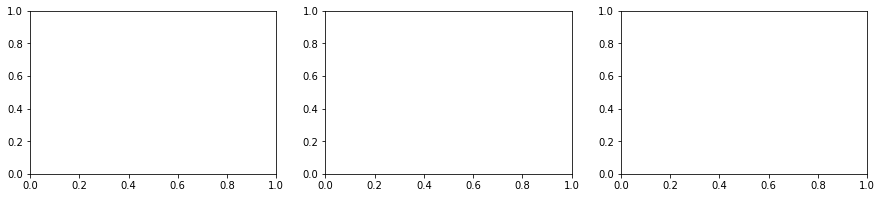

In [51]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb_multiclass.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

In [ ]:
Качество модели плохое, т.к. не удалось быстро подобрать оптимальные гиперпараметры для xgboost.  
Улучшить результат можно с использование feature engineering и более дета